In [7]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

# Part VI : reactor computations using our fuel

## 1. Ignition delay time

- A good ignition delay time tracer for NH3 + H2 combustion is the maximum gradient of the OH* species (OH in an excited state) [1]. The OH* formation sub-mechanism is included in the mechanism file.



In [8]:
def IDT_from_sim(states, times, sim, min_time):
    """ IDT from sim data"""
    OH = states[:, sim.global_component_index('OH*', 0)]
    OH = savgol_filter(OH, 21, 2)
    OH = OH/np.max(OH)
    dOH_dt = np.gradient(OH, times)
    s = len(times)//5
    s = np.min([s, 201])
    if s % 2 == 0:
        s += 1
    dOH_dt_f = savgol_filter(dOH_dt, s, 2)
    ids = np.where(np.array(times)>min_time)[0][0]
    idx = np.argmax(dOH_dt_f[ids:np.argmax(OH)]) + ids
    x = times[idx]
    y = OH[idx]
    a = np.max(dOH_dt_f)
    b = y - a*x
    d_x = np.linspace(x-1, x + 1, 100)
    d_y = d_x*a + b
    itrp = interp1d(d_y, d_x)
    idt = itrp(0)
    return idt

def IDT_compute(gas, temperature,  pressure, phi, fuel, min_time=0.000001):
    """ 
    Compute the ignition delay time for a cantera solution
    Based on the OH* max gradient intersection with the x axis (Mathieu, 2015)
    """
    gas.TP = temperature, pressure
    gas.set_equivalence_ratio(phi, fuel, {'O2':0.21, 'N2':0.79})
    r = ct.IdealGasReactor(contents=gas)
    sim = ct.ReactorNet([r])
    #sim.atol = 1e-20
    #sim.rtol = 1e-9
    sim.initialize()
    states = [sim.get_state()]
    times = [0]
    time = 0
    while states[-1][sim.global_component_index('NH3', 0)] > 1e-6:
        time = sim.step()
        states.append(sim.get_state())
        times.append(time)
    states = np.array(states)
    IDT = IDT_from_sim(states, times, sim, min_time)
    return IDT

/var/folders/2p/t043t32n4pgcxbh8xx3l1j0r0000gn/T/ipykernel_27854/3110883644.py:1: UserWarning: NasaPoly2::validate: 
For species OH*, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  53.62056162666667
	Value computed using high-temperature polynomial: 53.5841554314

  gas = ct.Solution('NH3_Xiao.yaml')


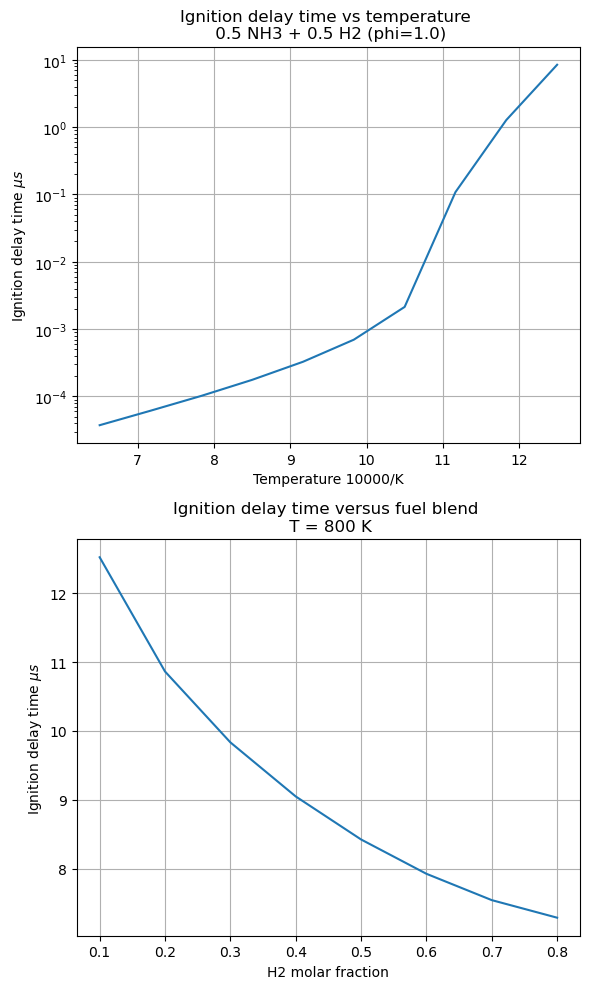

In [9]:
gas = ct.Solution('NH3_Xiao.yaml')

fig, axs = plt.subplots(2, 1, figsize=(6, 10))

ax = axs[0]
T_values = 10000/np.linspace(6.5, 12.5, 10)
idt_values = []
fuel = {'NH3':0.5, 'H2':0.5}
for T in T_values:
    idt = IDT_compute(gas, T , ct.one_atm, 1.0, fuel)
    idt_values.append(idt)
ax.plot(10000/T_values, idt_values)
ax.set_xlabel('Temperature 10000/K')
ax.set_yscale('log')
ax.set_title('Ignition delay time vs temperature \n 0.5 NH3 + 0.5 H2 (phi=1.0)')

ax = axs[1]
T = 800
X_values = np.arange(0.1, 0.81, 0.1)
idt_values = []
for Xi in X_values:
    fuel = {'NH3':(1-Xi), 'H2':Xi}
    idt = IDT_compute(gas, T, ct.one_atm, 1.0, fuel)
    idt_values.append(idt)
ax.plot(X_values, idt_values)
#ax.set_yscale('log')
ax.set_xlabel('H2 molar fraction')
ax.set_title('Ignition delay time versus fuel blend \n T = 800 K')

for ax in axs:
    ax.set_ylabel(r'Ignition delay time $\mu s$')
    ax.grid()

plt.tight_layout()

- Reaction is faster when the initial state is hotter
- IDT is slower compared to C8H18 (around 8.5 s versus 2.85 s) for the X(H2) = 0.5 blend
- When there is more hydrogen the mixture ignites faster
- The range if IDT when modifying the hydrogen molar fraction suggests that a blend can be made to obtain specific combustion properties

## 2. Pollutants versus residence time

In [10]:
def mass_to_phi(m):
    """ Convert the fuel mass flow rate to equivalence ratio """
    # Stochiometric mass fuel ratio
    FA_st = 0.110911
    # Actual mass fuel ratio
    # Air flow is always 240 kg/s
    FA = m/240
    phi = FA/FA_st
    return phi

def generate_sim_states(mdot, phi):
    """ 
    Fonction to generate a ReactorNetwork
    mdot : fuel mass flow rate
    phi : equivalence ratio
    """
    # Reservoir
    gas.TP = 800, 30 * ct.one_atm
    gas.set_equivalence_ratio(phi, {'NH3':0.5, 'H2':0.5}, {'O2':0.21, 'N2':0.79})
    inlet = ct.Reservoir(gas)
    # Define the combustor
    gas.TP = 2000, 30 * ct.one_atm
    combustor = ct.IdealGasReactor(gas)
    combustor.volume = 0.4
    # Define the exhaust
    gas.equilibrate('HP')
    exhaust = ct.Reservoir(gas)
    # Inlet and outlet
    inlet_mfc = ct.MassFlowController(inlet, combustor, mdot=(mdot))
    outlet_mfc = ct.PressureController(combustor, exhaust, master=inlet_mfc, K=0.1)
    # Simulation and states
    sim = ct.ReactorNet([combustor])
    return  sim, combustor

# Problem parameters
mass_values = np.arange(15, 57, 2) 
phi_values = mass_to_phi(mass_values)
gas = ct.Solution('NH3_Xiao.yaml')



/var/folders/2p/t043t32n4pgcxbh8xx3l1j0r0000gn/T/ipykernel_27854/3302276975.py:38: UserWarning: NasaPoly2::validate: 
For species OH*, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  53.62056162666667
	Value computed using high-temperature polynomial: 53.5841554314

  gas = ct.Solution('NH3_Xiao.yaml')


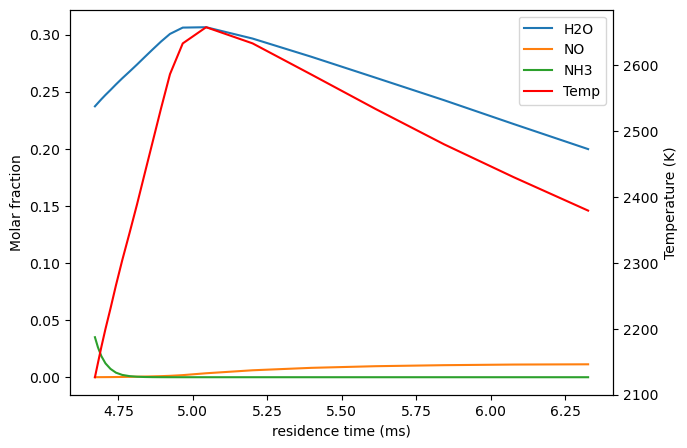

In [11]:
output = {}
output['T'] = []
output['H2O'] = []
output['NO'] = []
output['NH3'] = []
output['rt'] = []

for mdot, phi in zip(mass_values, phi_values):
    sim, combustor = generate_sim_states(mdot, phi)
    time = 0
    while time < 0.1:
        time = sim.step()
    output['T'].append(combustor.thermo.T)
    output['H2O'].append(combustor.thermo.X[gas.species_index('H2O')])
    output['NH3'].append(combustor.thermo.X[gas.species_index('NH3')])
    output['NO'].append(combustor.thermo.X[gas.species_index('NO')])
    output['rt'].append(1000 * combustor.mass / (240 + mdot))
    
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(output['rt'], output['H2O'], label='H2O')
ax.plot(output['rt'], output['NO'], label='NO')
ax.plot(output['rt'], output['NH3'], label='NH3')
ax.plot([], [], label='Temp', color='red')

ax2 = ax.twinx()
ax2.plot(output['rt'], output['T'], color='red')

ax.set_ylabel('Molar fraction')
ax.set_xlabel('residence time (ms)')
ax2.set_ylabel('Temperature (K)')
ax.legend()
plt.show()

## References

1. O. Mathieu and E. L. Petersen, “Experimental and modeling study on the high-temperature oxidation of Ammonia and related NOx chemistry,” Combustion and Flame, vol. 162, no. 3, pp. 554–570, Mar. 2015, doi: 10.1016/j.combustflame.2014.08.022.